In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.2.0 --progress-bar off
!pip install -qqq langgraph==0.2.22 --progress-bar off

In [21]:
import sqlite3
import textwrap
from enum import Enum, auto
from typing import List, Literal, Optional, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

np.random.seed(42)

MODEL = "mistral-large-v2"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("groq_api_key"))

# Agent Prompts

In [22]:
EDITOR_PROMPT = """
Rewrite for maximum social media engagement:

- Use attention-grabbing, concise language
- Inject personality and humor
- Optimize formatting (short paragraphs)
- Encourage interaction (questions, calls-to-action)
- Ensure perfect grammar and spelling
- Rewrite from first person perspective, when talking to an audience

Use only the information provided in the text. Think carefully.
"""

In [23]:
TWITTER_PROMPT = """
Generate a high-engagement tweet from the given text:
1. What problem does this solve?
2. Focus on the main technical points/features
3. Write a short, coherent paragraph (2-3 sentences max)
4. Use natural, conversational language
5. Optimize for virality: make it intriguing, relatable, or controversial
6. Exclude emojis and hashtags
"""


In [24]:

TWITTER_CRITIQUE_PROMPT = """
You are a Tweet Critique Agent. Your task is to analyze tweets and provide actionable feedback to make them more engaging. Focus on:

1. Clarity: Is the message clear and easy to understand?
2. Hook: Does it grab attention in the first few words?
3. Brevity: Is it concise while maintaining impact?
4. Call-to-action: Does it encourage interaction or sharing?
5. Tone: Is it appropriate for the intended audience?
6. Storytelling: Does it evoke curiosity?
7. Remove hype: Does it promise more than it delivers?

Provide 2-3 specific suggestions to improve the tweet's engagement potential.
Do not suggest hashtags. Keep your feedback concise and actionable.

Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""

In [25]:

LINKEDIN_PROMPT = """
Write a compelling LinkedIn post from the given text. Structure it as follows:

1. Eye-catching headline (5-7 words)
2. Identify a key problem or challenge
3. Provide a bullet list of key benefits/features
4. Highlight a clear benefit or solution
5. Conclude with a thought-provoking question

Maintain a professional, informative tone. Avoid emojis and hashtags.
Keep the post concise (50-80 words) and relevant to the industry.
Focus on providing valuable insights or actionable takeaways that will resonate
with professionals in the field.
"""

In [26]:
LINKEDIN_CRITIQUE_PROMPT = """
Your role is to analyze LinkedIn posts and provide actionable feedback to make them more engaging.
Focus on the following aspects:

1. Hook: Evaluate the opening line's ability to grab attention.
2. Structure: Assess the post's flow and readability.
3. Content value: Determine if the post provides useful information or insights.
4. Call-to-action: Check if there's a clear next step for readers.
5. Language: Suggest improvements in tone, style, and word choice.
6. Visual elements: Recommend additions or changes to images, videos, or formatting.

For each aspect, provide:
- A brief assessment (1-2 sentences)
- A specific suggestion for improvement
- A concise example of the suggested change

Conclude with an overall recommendation for the most impactful change the author can make to increase engagement.
Your goal is to help the writer improve their social media writing skills and increase engagement with their posts.
"""


# Graph

State

In [27]:
class Post(BaseModel):
    """A post written in different versions"""

    drafts: List[str]
    feedback: Optional[str]


class AppState(TypedDict):
    user_text: str
    target_audience: str
    edit_text: str
    tweet: Post
    linkedin_post: Post
    n_drafts: int

nodes


In [28]:
def editor_node(state: AppState):
    prompt = f"""
text:
```
{state["user_text"]}
```
""".strip()
    response = llm.invoke([SystemMessage(EDITOR_PROMPT), HumanMessage(prompt)])
    return {"edit_text": response.content}

In [29]:
def tweet_writer_node(state: AppState):

    post = state["tweet"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
Tweet:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(TWITTER_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"tweet": post}


In [30]:
def linkedin_writer_node(state: AppState):
    post = state["linkedin_post"]

    feedback_prompt = (
        ""
        if not post.feedback
        else f"""
LinkedIn post:
```
{post.drafts[-1]}
```

Use the feedback to improve it:
```
{post.feedback}
```
""".strip()
    )

    prompt = f"""
text:
```
{state["edit_text"]}
```

{feedback_prompt}

Target audience: {state["target_audience"]}

Write only the text for the post
""".strip()

    response = llm.invoke([SystemMessage(LINKEDIN_PROMPT), HumanMessage(prompt)])
    post.drafts.append(response.content)
    return {"linkedin_post": post}



In [31]:
def critique_tweet_node(state: AppState):
    post = state["tweet"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested tweet (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(TWITTER_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"tweet": post}

In [32]:
def critique_linkedin_node(state: AppState):
    post = state["linkedin_post"]

    prompt = f"""
Full post:
```
{state["edit_text"]}
```

Suggested LinkedIn post (critique this):
```
{post.drafts[-1]}
```

Target audience: {state["target_audience"]}
""".strip()

    response = llm.invoke(
        [SystemMessage(LINKEDIN_CRITIQUE_PROMPT), HumanMessage(prompt)]
    )
    post.feedback = response.content
    return {"linkedin_post": post}


In [33]:
def supervisor_node(state: AppState):
    return state

Edges

In [34]:

def should_rewrite(
    state: AppState,
) -> Literal[["linkedin_critique", "tweet_critique"], END]:
    tweet = state["tweet"]
    linkedin_post = state["linkedin_post"]
    n_drafts = state["n_drafts"]
    if len(tweet.drafts) >= n_drafts and len(linkedin_post.drafts) >= n_drafts:
        return END

    return ["linkedin_critique", "tweet_critique"]

# Build a Graph

In [35]:
graph = StateGraph(AppState)

graph.add_node("editor", editor_node)
graph.add_node("tweet_writer", tweet_writer_node)
graph.add_node("tweet_critique", critique_tweet_node)
graph.add_node("linkedin_writer", linkedin_writer_node)
graph.add_node("linkedin_critique", critique_linkedin_node)
graph.add_node("supervisor", supervisor_node)

graph.add_edge("editor", "tweet_writer")
graph.add_edge("editor", "linkedin_writer")

graph.add_edge("tweet_writer", "supervisor")
graph.add_edge("linkedin_writer", "supervisor")
graph.add_conditional_edges("supervisor", should_rewrite)

graph.add_edge("tweet_critique", "tweet_writer")
graph.add_edge("linkedin_critique", "linkedin_writer")

graph.set_entry_point("editor")

app = graph.compile()

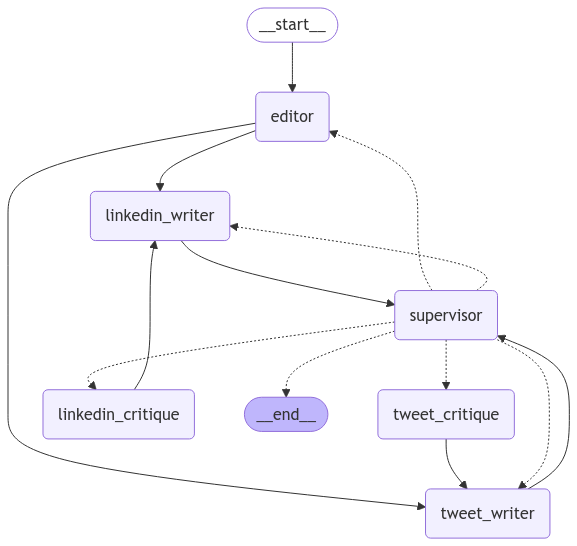

In [36]:

display(Image(app.get_graph().draw_mermaid_png()))